In [5]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Data Analysis").getOrCreate()

## Topics Covered

* **SparkSession**
    * read <format / option/ load>
    
* **DataFrames**
    * printSchema
    * count
    * dropna
    * drop
    * select, distinct
    * filter
    * sample
    * groupBy
    * agg : sum,avg,min,max
    * describe
    * crosstab
    * toLocalIterator
* **pyspark.sql.functions**
    * round
* **matplotlib inline**
    

In [6]:
data=spark.read.format("CSV").option("header","true").load("./datasets/london_crime_by_lsoa.csv")
data.printSchema()

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)



In [7]:
data.count()

13490604

In [8]:
data.limit(5).show()

+---------+----------+--------------------+--------------------+-----+----+-----+
|lsoa_code|   borough|      major_category|      minor_category|value|year|month|
+---------+----------+--------------------+--------------------+-----+----+-----+
|E01001116|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+---------+----------+--------------------+--------------------+-----+----+-----+



In [9]:
#drop values that are not available
data.dropna()
data.count()

13490604

In [10]:
#Drop useless columns
data=data.drop("lsoa_code")
data.show(3)

+---------+--------------------+--------------------+-----+----+-----+
|  borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+-----+----+-----+
|  Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|  Bromley|Violence Against ...|      Other violence|    0|2015|    5|
+---------+--------------------+--------------------+-----+----+-----+
only showing top 3 rows



In [11]:
unique_borough=data.select('borough').distinct()
unique_borough.count()

33

In [12]:
hackney_data = data.filter(data['borough']=="Hackney")
hackney_data.show(3)

+-------+--------------------+--------------------+-----+----+-----+
|borough|      major_category|      minor_category|value|year|month|
+-------+--------------------+--------------------+-----+----+-----+
|Hackney|     Criminal Damage|Criminal Damage T...|    0|2011|    6|
|Hackney|Violence Against ...|          Harassment|    1|2013|    2|
|Hackney|     Criminal Damage|Other Criminal Da...|    0|2011|    7|
+-------+--------------------+--------------------+-----+----+-----+
only showing top 3 rows



In [13]:
data_15_16= data.filter(data['year'].isin(['2015','2016']))
data_15_16.sample(fraction=0.000001).show()

+--------+------------------+--------------------+-----+----+-----+
| borough|    major_category|      minor_category|value|year|month|
+--------+------------------+--------------------+-----+----+-----+
|Haringey|   Criminal Damage|Criminal Damage T...|    0|2015|    7|
|  Merton|Theft and Handling|Theft From Motor ...|    0|2015|    9|
|  Bexley|Theft and Handling|Handling Stolen G...|    0|2015|    9|
+--------+------------------+--------------------+-----+----+-----+



In [14]:
data_15_16= data.filter(data['year']<2015)
data_15_16.sample(fraction=0.1).show(3)

+-----------+--------------------+--------------------+-----+----+-----+
|    borough|      major_category|      minor_category|value|year|month|
+-----------+--------------------+--------------------+-----+----+-----+
|     Sutton|               Drugs| Possession Of Drugs|    0|2009|   10|
|Westminster|  Theft and Handling|Handling Stolen G...|    0|2012|    2|
|     Newham|Violence Against ...|          Harassment|    3|2009|    5|
+-----------+--------------------+--------------------+-----+----+-----+
only showing top 3 rows



In [15]:
borough_crime_count=data.groupBy('borough').count()
borough_crime_count.show(5)

+--------------------+------+
|             borough| count|
+--------------------+------+
|             Croydon|602100|
|          Wandsworth|498636|
|              Bexley|385668|
|             Lambeth|519048|
|Barking and Dagenham|311040|
+--------------------+------+
only showing top 5 rows



In [16]:
borough_conviction_sum=data.groupBy('borough').agg({"value":"sum"}).withColumnRenamed('sum(value)','convictions')
borough_conviction_sum.show(5)

+--------------------+-----------+
|             borough|convictions|
+--------------------+-----------+
|             Croydon|   260294.0|
|          Wandsworth|   204741.0|
|              Bexley|   114136.0|
|             Lambeth|   292178.0|
|Barking and Dagenham|   149447.0|
+--------------------+-----------+
only showing top 5 rows



In [17]:
borough_conviction_sum.agg({"convictions":"avg"}).show()

+------------------+
|  avg(convictions)|
+------------------+
|195386.60606060605|
+------------------+



In [18]:
total_conviction=borough_conviction_sum.agg({"convictions":"sum"}).collect()[0][0]
total_conviction

6447758.0

In [19]:
import pyspark.sql.functions as func

In [20]:
borough_percentage_contribution = borough_conviction_sum.withColumn(
    '%contribution',
    func.round(borough_conviction_sum.convictions/total_conviction*100,2))
borough_percentage_contribution.printSchema()

root
 |-- borough: string (nullable = true)
 |-- convictions: double (nullable = true)
 |-- %contribution: double (nullable = true)



In [21]:
borough_percentage_contribution.orderBy(borough_percentage_contribution[2].desc()).show(5)

+-----------+-----------+-------------+
|    borough|convictions|%contribution|
+-----------+-----------+-------------+
|Westminster|   455028.0|         7.06|
|    Lambeth|   292178.0|         4.53|
|  Southwark|   278809.0|         4.32|
|     Camden|   275147.0|         4.27|
|     Newham|   262024.0|         4.06|
+-----------+-----------+-------------+
only showing top 5 rows



In [22]:
year_df=data.select("year")

In [24]:
year_df.agg({'year':'min'}).show()

+---------+
|min(year)|
+---------+
|     2008|
+---------+



In [25]:
year_df.agg({'year':'max'}).show()

+---------+
|max(year)|
+---------+
|     2016|
+---------+



In [27]:
year_df.describe().show()

+-------+-----------------+
|summary|             year|
+-------+-----------------+
|  count|         13490604|
|   mean|           2012.0|
| stddev|2.581988993167432|
|    min|             2008|
|    max|             2016|
+-------+-----------------+



In [31]:
data.show()

+--------------------+--------------------+--------------------+-----+----+-----+
|             borough|      major_category|      minor_category|value|year|month|
+--------------------+--------------------+--------------------+-----+----+-----+
|             Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|           Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|             Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|           Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|          Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
|              Ealing|  Theft and Handling|         Other Theft|    0|2012|    5|
|              Ealing|Violence Against ...|    Offensive Weapon|    0|2010|    7|
|            Hounslow|             Robbery|   Personal Property|    0|2013|    4|
|              Newham|     Criminal Damage|Criminal Damage T...|    0|2013|    9|
|              S

In [33]:
data.crosstab('borough', 'major_category').show()

+----------------------+--------+---------------+-----+----------------+-------------------------+-------+---------------+------------------+---------------------------+
|borough_major_category|Burglary|Criminal Damage|Drugs|Fraud or Forgery|Other Notifiable Offences|Robbery|Sexual Offences|Theft and Handling|Violence Against the Person|
+----------------------+--------+---------------+-----+----------------+-------------------------+-------+---------------+------------------+---------------------------+
|              Havering|   32400|          64152|32616|            5508|                    21060|  27648|           1944|            118800|                      95472|
|                Merton|   26784|          52920|29160|            5724|                    19440|  23652|           2592|            101196|                      78408|
|              Haringey|   31320|          62424|35424|           10368|                    23760|  29484|           3780|            120420|         

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

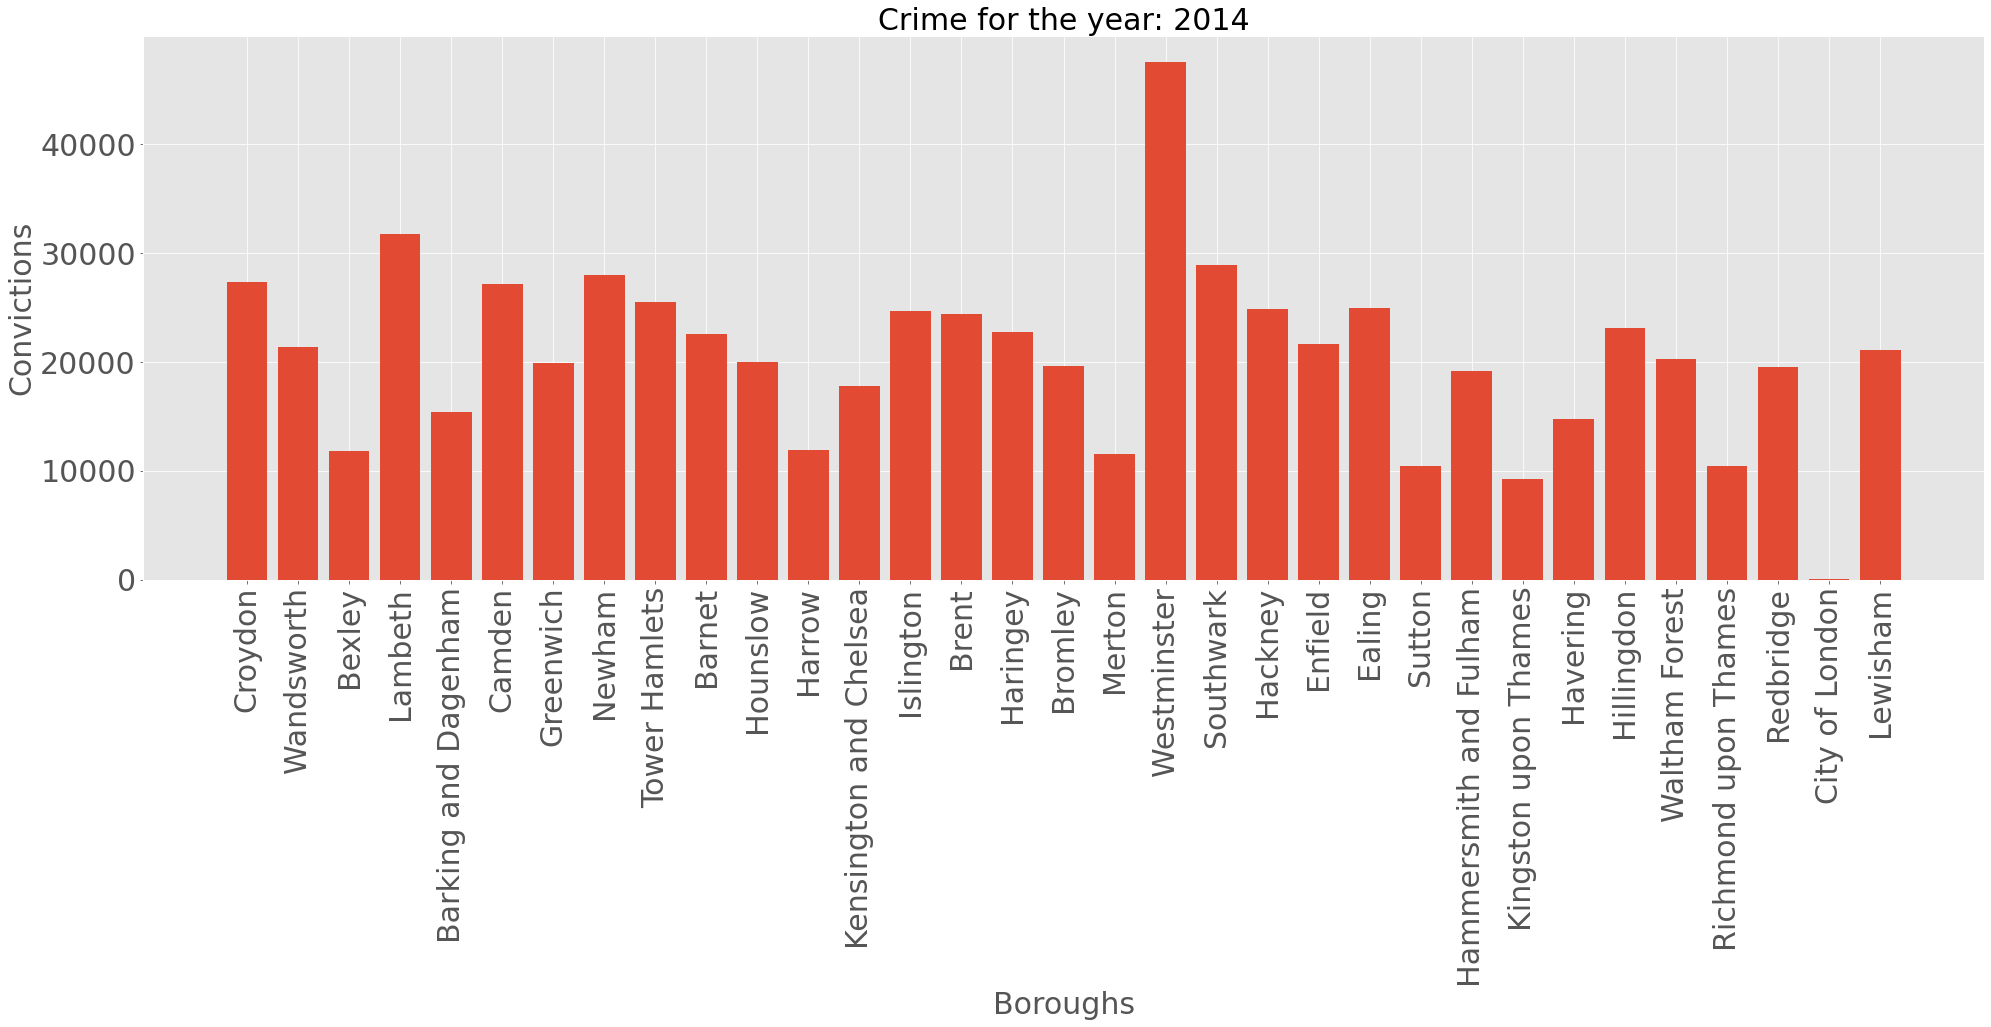

In [4]:
def describe_year(year):
    yearly_details = data.filter(data.year == year)\
                         .groupBy('borough')\
                         .agg({'value':'sum'})\
                         .withColumnRenamed("sum(value)","convictions")
    
    borough_list = [x[0] for x in yearly_details.toLocalIterator()]
    convictions_list = [x[1] for x in yearly_details.toLocalIterator()]
  
    plt.figure(figsize=(33, 10)) 
    plt.bar(borough_list, convictions_list)
    
    plt.title('Crime for the year: ' + year, fontsize=30)
    plt.xlabel('Boroughs',fontsize=30)
    plt.ylabel('Convictions', fontsize=30)

    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.autoscale()
    plt.show()
describe_year('2014')